# Set weight

In [1]:
import sys
sys.path.append('../')
import numpy as np
from c200_sdk.sdk_array_newsystem import SDKArray
from C200_utils import *
from config_weight_bayes_0518 import *

# select the array
sdk = SDKArray(0)

write_repeat = 1

if __name__ == '__main__':
    # write the weight matrices five times to ensure accuracy
    for i in range(write_repeat):
        sdk.set_weight(weight = f1_q_mapping_repeat, addr = addr_f1, verbose = 0)
        print(f'Set f1 {i+1} times !!')
        sdk.set_weight(weight = f2_q_mapping_repeat, addr = addr_f2, verbose = 0)
        print(f'Set f2 {i+1} times !!')
        sdk.set_weight(weight = fc1_q_mapping_repeat, addr = addr_fc1, verbose = 0)
        print(f'Set fc1 {i+1} times !!')
        sdk.set_weight(weight = fc2_q_mapping_repeat, addr = addr_fc2, verbose = 0)
        print(f'Set fc2 {i+1} times !!')



[0, 0, 576, 32]
[0, 32, 576, 32]
[0, 64, 576, 48]
[0, 112, 480, 10]
libBaseApi version:11
初始化
选片
(576, 32)
(576, 32)
cell_total_num:18432


Cycle = 1
Progress at 100.00 %
Total time used: 0:00:48
Mapping success rate: 18432 / 18432, 100.0000
Operation success rate: 16353 / 16353, 100.0000


Cycle = 2
Progress at 100.00 %
Total time used: 0:01:13
Mapping success rate: 18432 / 18432, 100.0000
Operation success rate: 11935 / 11935, 100.0000


Cycle = 3
Progress at 100.00 %
Total time used: 0:01:31
Mapping success rate: 18432 / 18432, 100.0000
Operation success rate: 10107 / 10107, 100.0000


Cycle = 4
Progress at 100.00 %
Total time used: 0:01:46
Mapping success rate: 18432 / 18432, 100.0000
Operation success rate: 9119 / 9119, 100.0000


Cycle = 5
Progress at 100.00 %
Total time used: 0:01:59
Mapping success rate: 18432 / 18432, 100.0000
Operation success rate: 8593 / 8593, 100.0000
Set f1 1 times !!
(576, 32)
(576, 32)
cell_total_num:18432


Cycle = 1
Progress at 100.00 %
Total time use

# Infer

In [2]:
# -*- coding: utf-8 -*-
"""
Created on Tue Nov 23 19:01:34 2021

@author: kidwz
"""
import sys
sys.path.append('../')
import numpy as np
import matplotlib.pyplot as plt
from c200_sdk.sdk_array_newsystem import SDKArray
from C200_module import *
from config_weight import *
import pickle as pkl
from tqdm import tqdm

# ========================================= #
# 设置
# ========================================= #
# 推理图片数量, 最多 10000 张
inference_imgs = 100
img_half_level = 7
feature_map_half_level = 15

# ========================================= #
# 读取图片
# ========================================= #
imgs = np.load('dataset_imgs_10000.npy')
labels = np.load('dataset_labels_10000.npy')

# ========================================= #
# 开始推理
# ========================================= #
# 计算准确率
count_match = 0
count_tot = 0

# ========================================= #
# 选片
# ========================================= #
sdk = SDKArray(0)

# ========================================= #
# 调整积分时间
# ========================================= #
time_start = time.time()
# 理想情况下该任务精度约为 85%
it_time = [3, 9, 10, 5]

# ========================================= #
# 定义Labels
# ========================================= #
label_list = ['T-shirt/top',
              'Trouser',
              'Pullover',
              'Dress',
              'Coat',
              'Sandal',
              'Shirt',
              'Sneaker',
              'Bag',
              'Ankle boot']
# ========================================= #
# 开始推理
# ========================================= #
for batch_index in range(inference_imgs):
    # batch_index = 39
    print('')
    print('# =================================================================== #')
    print(f'Predicting Img #{batch_index}')
    # print(f'it_time = {it_time}')
    time_img = time.time()
    # 读取数据
    img = imgs[batch_index]
    label = labels[batch_index]
    plot_ascii_img(img[0], spacing = 1)
    # ========================================= #
    # 逐层计算, network_flow 中包含了所有层的类和计算流程
    # ========================================= #
    print(f'calculating layer Conv 1')
    conv1_out = conv2d_144k(sdk, img, addr_f1, f1_repeat,
                            f1_stride, f1_kernel_size, f1_padding,
                            img_half_level, feature_map_half_level,
                            it_time = it_time[0], input_quant = True)
    conv1_out_pool = pooling(conv1_out, 2)
    print(f'calculating layer Conv 2')
    conv2_out = conv2d_144k(sdk, conv1_out_pool, addr_f2, f2_repeat,
                            f2_stride, f2_kernel_size, f2_padding,
                            feature_map_half_level, feature_map_half_level,
                            it_time = it_time[1], input_quant = True)
    conv2_out_pool = pooling(conv2_out, 2)
    print(f'calculating layer FC 1')
    fc1_out = linear_144k(sdk, conv2_out_pool, addr_fc1, fc1_repeat,
                          feature_map_half_level, feature_map_half_level,
                          it_time = it_time[2])
    print(f'calculating layer FC 2')
    fc2_out = linear_144k(sdk, fc1_out, addr_fc2, fc2_repeat,
                          feature_map_half_level, feature_map_half_level,
                          it_time = it_time[3])

    # ========================================= #
    # 计算精度 打印结果
    # ========================================= #
    predict = np.where(fc2_out == fc2_out.max())[1][0]
    print('')
    print(f'Prediction is [{label_list[predict]}]')
    print(f'Lable is [{label_list[label]}]')
    if predict == label:
        count_match += 1
        print('')
        print(f'CORRECT !!')
    else:
        print('')
        print('WRONG !!')

    time_cur_img = time.time() - time_img
    # 统计准确率
    accuracy = count_match / (batch_index + 1) * 100
    print('')
    print(f"Cumulative Accuracy = {accuracy:.2f}%")
    print(f'Calculation time for this img = {time_cur_img}s')

# 统计准确率
print("Accuracy =", count_match / inference_imgs * 100, "%")

time_tot = time.time() - time_start
time_avg = time_tot / (inference_imgs + 1)
print("Average Inference Time per Img =", time_avg, " s")

# # 计算准确率
# count_match = 0
# count_tot = 0

# # ========================================= #
# # 选片
# # ========================================= #
# sdk = None

# # ========================================= #
# # 调整积分时间
# # ========================================= #
# time_start = time.time()
# it_time = [6, 6, 6, 6]


# f1_repeat = [1, 1]
# f2_repeat = [1, 1]
# fc1_repeat = [1, 1]
# fc2_repeat = [1, 1]
# # ========================================= #
# # 开始推理
# # ========================================= #
# for batch_index in tqdm(range(inference_imgs)):
# # for batch_index in [1]:
#     # batch_index = 39
#     # print('')
#     # print('# =================================================================== #')
#     # print(f'Predicting Img #{batch_index}')
#     # print(f'it_time = {it_time}')
#     time_img = time.time()
#     # 读取数据
#     img = imgs[batch_index]
#     label = labels[batch_index]
#     # plot_ascii_img(img[0], spacing = 1)
#     # ========================================= #
#     # 逐层计算, network_flow 中包含了所有层的类和计算流程
#     # ========================================= #
#     # print(f'calculating layer Conv 1')
#     conv1_out = conv2d_sim(sdk, img, f1_q_mapping-8, f1_repeat,
#                             f1_stride, f1_kernel_size, f1_padding,
#                             img_half_level, feature_map_half_level,
#                             it_time = it_time[0], input_quant = True)
#     conv1_out_pool = pooling(conv1_out, 2)
#     # print(f'calculating layer Conv 2')
#     conv2_out = conv2d_sim(sdk, conv1_out_pool, f2_q_mapping-8, f2_repeat,
#                             f2_stride, f2_kernel_size, f2_padding,
#                             feature_map_half_level, feature_map_half_level,
#                             it_time = it_time[1], input_quant = True)
#     conv2_out_pool = pooling(conv2_out, 2)
#     # print(f'calculating layer FC 1')
#     fc1_out = linear_sim(sdk, conv2_out_pool, fc1_q_mapping-8, fc1_repeat,
#                           feature_map_half_level, feature_map_half_level,
#                           it_time = it_time[2], input_quant=True)
#     # print(f'calculating layer FC 2')
#     fc2_out = linear_sim(sdk, fc1_out, fc2_q_mapping-8, fc2_repeat,
#                           feature_map_half_level, feature_map_half_level,
#                           it_time = it_time[3], input_quant=True)

#     # ========================================= #
#     # 计算精度 打印结果
#     # ========================================= #
#     predict = np.where(fc2_out == fc2_out.max())[1][0]
#     # predict = np.where(fc2_out == fc2_out.max())[1][0]
#     # print('')
#     # print(f'Prediction is [{label_list[predict]}]')
#     # print(f'Lable is [{label_list[label]}]')
#     if predict == label:
#         count_match += 1
#     #     print('')
#     #     print(f'CORRECT !!')
#     # else:
#     #     print('')
#     #     print('WRONG !!')

#     time_cur_img = time.time() - time_img
#     # 统计准确率
#     accuracy = count_match / (batch_index + 1) * 100
#     # print('')
#     # print(f"Cumulative Accuracy = {accuracy:.2f}%")
#     # print(f'Calculation time for this img = {time_cur_img}s')

# # 统计准确率
# print("Accuracy =", count_match / inference_imgs * 100, "%")

# time_tot = time.time() - time_start
# time_avg = time_tot / (inference_imgs + 1)
# print("Average Inference Time per Img =", time_avg, " s")

[0, 0, 576, 32]
[0, 32, 576, 32]
[0, 64, 576, 48]
[0, 112, 480, 10]

# =================================================================== #
Predicting Img #0
----------------------------------------------------------
|                                                        |
|                                                        |
|                                                        |
|                                                        |
|                                                        |
|                                                        |
|                                                        |
|                                                  .     |
|                                . :               -     |
|                                : + -         . - -     |
|                              . + - + * + * + + * +     |
|                              + + + + * + * * + + +     |
|                            - - - + * + + * * + + +     |
|              

# LOG

|Item   |Train Time |Train Epochs |Train Total Time |Set Time   |Test Time   |Accu   |Date    |
|---    |---    |---    |---    |---    |---    |---    |---    |
|Default  |-  |-  |-  |6m13s  |2m16s  |84%    |0517    |
|ERM  |8s/Epoch  |100  |~20m  |4m20s  |  2m13s|%    |0518    |
|Bayes  |11s/Epoch  |10x10  |4m20s  |  |  |%    |0518    |

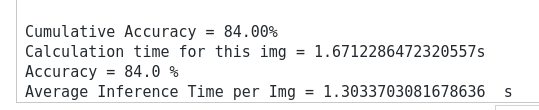